In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from scipy.optimize import curve_fit
from scipy import stats

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import dataloader as dl
import bandpower


# Import data

In [2]:
X, Y_class, Y_reg, channels = dl.read_data([2], list(range(11)), 'class')
Y = np.concatenate((Y_class[:,np.newaxis], Y_reg[:,np.newaxis]), axis=1)

root_path = '/Users/hundredball/Desktop/Project_Predict/Math24/'

# Get list of data names
df_names = pd.read_csv('%s/Data_Matlab/data_list.csv'%(root_path))
data_names = [x[0:6] for x in df_names.values.flatten()]

Event 1 X shape:  (324, 12, 512)
Event 2 X shape:  (546, 12, 512)
Event 3 X shape:  (226, 12, 512)
Combined X shape:  (546, 12, 512)
After removing outliers, X shape:  (544, 12, 512)
Mean of all trials: 13.408426


# Data preprocessing

In [7]:
# Order of channels
channel_order = pd.read_csv('%s/Channel_coordinate/Channel_location_angle.csv'%(root_path))['Channel'].values

# Arrange all the channels in the same order
for i in range(X.shape[0]):
    date = channels[i]

    # Read channel locations
    channel_info = pd.read_csv('%s/Channel_coordinate/%s_channels_class.csv'%(root_path, data_names[date]))
    channel_info = channel_info.to_numpy()
    
    # Change the order of data
    temp_X = np.array([X[i, np.where(channel_order[j]==channel_info[:,1])[0], :] for j in range(X.shape[1])])
    temp_X = temp_X.reshape((X.shape[1], -1))
    X[i,:] = temp_X

# Time frequency analysis
'''
freq, t, Zxx  = bandpower.STFT(X, Y_reg, 2, 30)
print('Shape of Zxx: ', Zxx.shape)
powers = bandpower.get_bandpower(X, [10], [15])
print('Shape of powers: ', powers.shape)
'''

"\nfreq, t, Zxx  = bandpower.STFT(X, Y_reg, 2, 30)\nprint('Shape of Zxx: ', Zxx.shape)\npowers = bandpower.get_bandpower(X, [10], [15])\nprint('Shape of powers: ', powers.shape)\n"

In [4]:
method = 2 # 1,2,3
if method != 3:
    # Concatenate over channels (PCA -> LDA)
    Zxx = Zxx.reshape((X.shape[0], -1))
    print('Shape of Zxx: ', Zxx.shape)
else:
    # Average power over channels (LDA directly)
    Zxx = np.mean(Zxx, axis=2)
    print('Shape of Zxx: ', Zxx.shape)
    powers = powers.reshape((powers.shape[0], -1))
    print('Shape of powers: ', powers.shape)

Shape of Zxx:  (544, 684)


# Holdout Method

## Split data

In [5]:
# Split for training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(Zxx, Y, test_size=0.1, random_state=42)
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

X_train shape :  (489, 684)
X_test shape :  (55, 684)


## PCA (1) Largest eigenvalues

In [29]:
# Apply PCA to training data and testing data
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)

X_train shape :  (489, 2)
X_test shape :  (55, 2)


## PCA (2) Most correlated

In [5]:
def PCA_corr(X_train, X_test, Y_train):
    # PCA fit
    num_train = X_train.shape[0]
    mean_X = 1/num_train * np.dot(X_train.T, np.ones((num_train,1))).T
    cen_X_train = X_train - mean_X
    cov_X_train = 1/num_train * np.dot(cen_X_train.T, cen_X_train)
    w, v = np.linalg.eig(cov_X_train)

    # Sort the eigenvalues and eigenvectors in decreasing order
    sorted_indices = np.argsort(w)[::-1]
    sorted_v = v[:, sorted_indices]
    sorted_w = np.sort(w)[::-1]

    # Retain PCs with 80% eigenvalues
    ratios = np.add.accumulate(sorted_w.real)/np.sum(sorted_w.real)
    num_PCs = np.sum(ratios<=0.8)
    PCs = sorted_v[:, :num_PCs]

    # PCA predict
    X_train = np.dot(cen_X_train, PCs)

    # Find two PCs correlated most strongly with SLs
    corr_coef = np.zeros(num_PCs)
    for i in range(num_PCs):
        corr_coef[i] = abs(np.corrcoef(X_train[:,i], Y_train[:,1])[0,1])

    max_1_index = np.argmax(corr_coef)
    #print('Max: ', max_1_index)
    corr_coef[max_1_index] = 0
    max_2_index = np.argmax(corr_coef)
    #print('Second: ', max_2_index)
    PC_2 = sorted_v[:, [max_1_index, max_2_index]]

    # PCA predict
    X_train = abs(np.dot(cen_X_train, PC_2))
    X_test = abs(np.dot(X_test-mean_X, PC_2))

    #print('X_train shape : ', X_train.shape)
    #print('X_test shape : ', X_test.shape)
    
    return X_train, X_test

In [7]:
X_train, X_test = PCA_corr(X_train, X_test, Y_train)

In [8]:
# Sort SLs in increasing order
sorted_indices = np.argsort(Y_train[:,1])
sorted_x = X_train[sorted_indices, :]
sorted_y = Y_train[sorted_indices, :]

# Curve fitting
def func(X, a, b, c):
    x1, x2 = X
    return a + b*x1 + c*x2

xdata = (sorted_x[:,0], sorted_x[:,1])
ydata = sorted_y[:,1]
popt, pcov = curve_fit(func, xdata, ydata)

Text(0.5, 1.0, 'r = 0.189289')

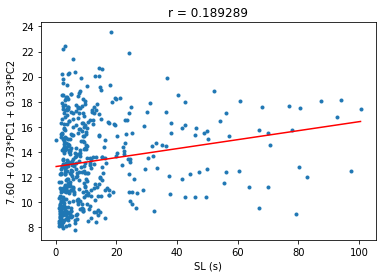

In [9]:
# Plot them
y_reg = func(xdata, popt[0], popt[1], popt[2])
plt.scatter(ydata, y_reg, marker = '.')

slope, intercept, r_value, p_value, std_err = stats.linregress(ydata, y_reg)
y_range = np.linspace(np.min(ydata), np.max(ydata), 100)
plt.plot(y_range, slope*y_range+intercept, 'r-')

plt.xlabel('SL (s)')
plt.ylabel('%.2f + %.2f*PC1 + %.2f*PC2'%(popt[0],popt[1],popt[2]))
plt.title('r = %f'%(np.corrcoef(y_reg, ydata)[0,1]))


In [10]:
np.mean(Zxx)

0.04077526630948172

## Binary classification

In [12]:
# Decompose Y
Y_train = Y_train[:,0]
Y_test = Y_test[:,0]

clf = LDA()
clf.fit(X_train, Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [13]:
num_train = len(Y_train)
pred_train = clf.predict(X_train)

print('Training : (%d, %d)'%(np.sum(pred_train == Y_train), num_train))
print('Accuracy : %f'%(np.sum(pred_train == Y_train)/num_train*100))

num_test = len(Y_test)
pred_test = clf.predict(X_test)

print('Testing : (%d, %d)'%(np.sum(pred_test == Y_test), num_test))
print('Accuracy : %f'%(np.sum(pred_test == Y_test)/num_test*100))

Training : (357, 489)
Accuracy : 73.006135
Testing : (39, 55)
Accuracy : 70.909091


# Leave-one-out cross validation

In [6]:
if method != 3:
    X_all = Zxx
else:
    X_all = powers

train_acc_list = []
test_acc_list = []
loo = LeaveOneOut()
for i, (train_index, test_index) in enumerate(loo.split(X_all)):
    # Split data
    X_train, X_test = X_all[train_index], X_all[test_index]
    Y_train, Y_test = Y[train_index, :], Y[test_index, :]
    
    if method == 1:
        pca = PCA(n_components=2)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    elif method == 2:
        # PCA
        X_train, X_test = PCA_corr(X_train, X_test, Y_train)
    
    # Decompose Y
    Y_train = Y_train[:,0]
    Y_test = Y_test[:,0]
    
    # LDA
    clf = LDA()
    clf.fit(X_train, Y_train)
    
    num_train = len(Y_train)
    pred_train = clf.predict(X_train)
    train_acc = np.sum(pred_train == Y_train)/num_train*100
    #print('Training Accuracy : %f'%(train_acc))
    train_acc_list.append(train_acc)

    num_test = len(Y_test)
    pred_test = clf.predict(X_test)
    test_acc = np.sum(pred_test == Y_test)*100
    #print('Testing Accuracy : %f'%(test_acc))
    test_acc_list.append(test_acc)
    
    print('Iteration %d'%(i))
    

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [7]:
print('Training accuracy: %f'%(sum(train_acc_list)/len(train_acc_list)))
print('Testing accuracy: %f'%(sum(test_acc_list)/len(test_acc_list)))

Training accuracy: 72.794118
Testing accuracy: 72.794118
